# Creating Node Representation with DeepWalk

In this notebook we will take a deepdive into the DeepWalk algorithm, which is used for building graph representations that are then fed into downstream tasks. We will look into architecture of DeepWalk and it's two major component:

- Word2Vec
- Random Walks

For the Word2Vec algorithm we will especifically focus on the Skip-gram model. While working on the DeepWalk algorithm we will also focus on the **hierarchical softmax (H-Softmax)** function. 

We will also implement the *Random Walk* algorithm before ending the notebook with an end-to-end *supervised classification* exercise on Zachary's Karate Club.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from gensim.models.word2vec import Word2Vec

# 1. The Skip-gram Model

In a skip-gram model, given a *single* word, we need to predict it's *surrounding words (context words)*. So on a rough level this is what it looks like:

<div>
    <img src="../imgs/skip-gram.png" width=800/>
</div>


The Skip-gram model produces **more accurate** representation of words compared to CBOW model.

 # 2. DeepWalk and random walks

 - Proposed by Perozzi et al. in 2014, DeepWalk became an extremely popular among graph researchers.
 - DeepWalk is a **simple reliable baseline** that can be quickly implemented to solve a lot of problem.
 - The goal of DeepWalk is to produce **high quality** feature representations of nodes in an **unsupervised way**.
 - The architecture of the DeepWalk algorithm is heavily inspired by the **Word2Vec** algorithm. However instead of words, the dataset is composed of **nodes** in this case.
 - The use of **random walks** is to generate meaningful sequences of nodes that act like sentences.
 - Random walks are **sequences of nodes** produced by randomly choosing a neighbor at every step.
 - Even if the nodes are randomly selected, the fact that two nodes appear together often in a sequence means that they are close to each other.
 - Under the **network homophily** hypothesis, nodes that are close to each other are similar.

## 2.1 Implementing Random Walks

/home/datum/ai/graph_ml/.venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


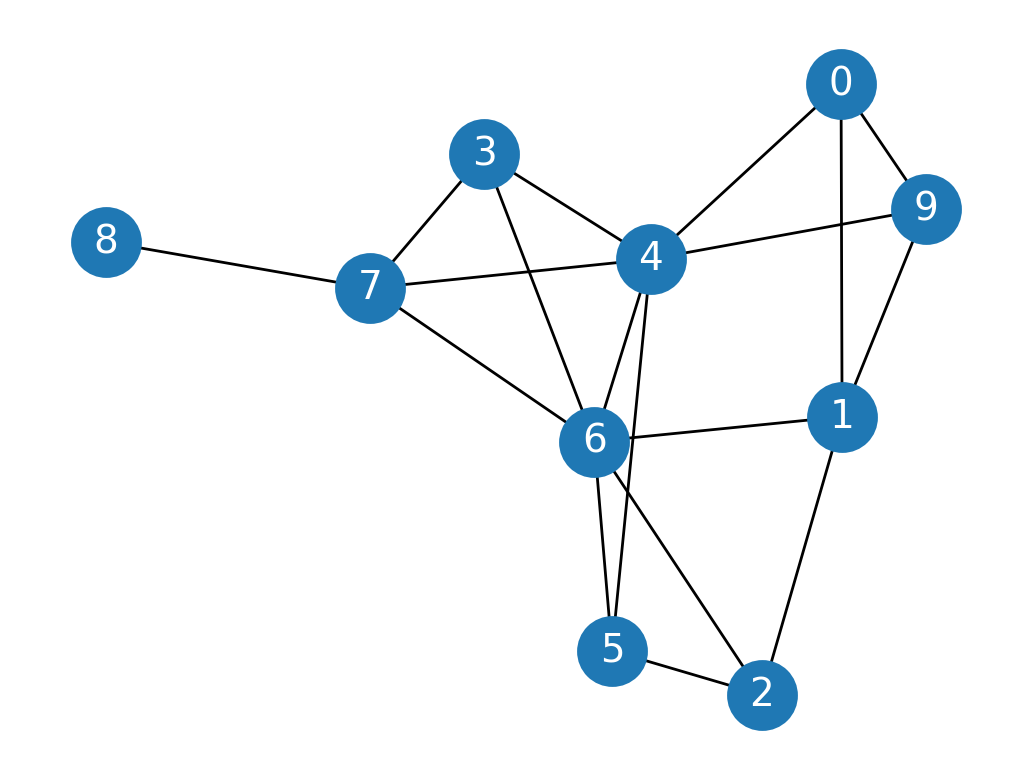

In [2]:
G = nx.erdos_renyi_graph(10, .3, seed=1, directed=False)
plt.figure(dpi=200)
plt.axis("off")
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0),
                 node_size=600, 
                 cmap="coolwarm", 
                 font_size=14, 
                 font_color="white")

In [3]:
def random_walk(start: int, length: int):
    """Performs the random walk algorithm"""
    walk = [str(start)]

    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors, size=1)[0]
        walk.append(str(next_node))
        start = next_node
        
    return walk

In [4]:
print(random_walk(0, 10))

['0', '1', '0', '4', '5', '2', '5', '6', '3', '7', '4']


We can see that certain nodes such as $0$ and $9$ are found to occur together. Considering that it is a **homophilic graph**, it means that it is similar.

## 2.2 Implementing DeepWalk

- We are going to use the **karate club dataset**
- This dataset represents the relationships within a karate club. It is kind of a social graph where every node is a member, and members who interact outside the club are connected.
- The dataset is divided into 2 groups, we would like to assign the right group to every member (i.e. node classification) just by looking at their connections.

In [5]:
G = nx.karate_club_graph()

labels = list()
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == "Officer" else 0)


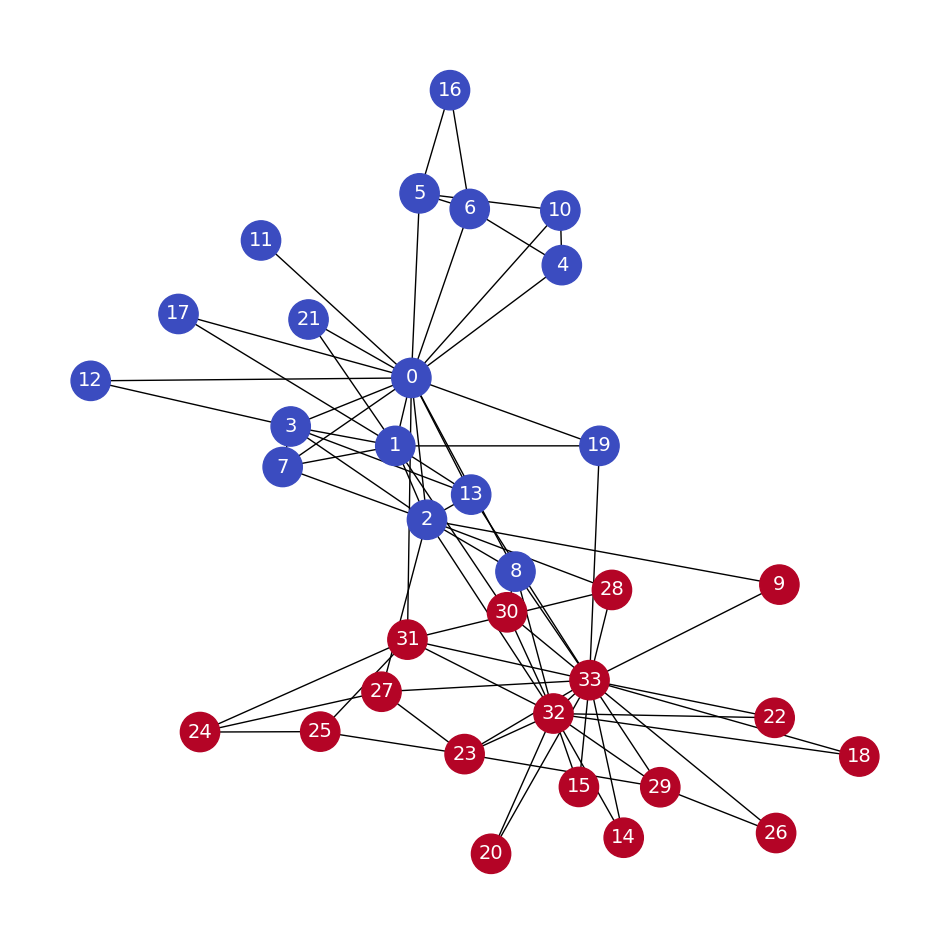

In [6]:
plt.figure(figsize=(12, 12), dpi=100)
plt.axis("off")
nx.draw_networkx(G, 
                 pos=nx.spring_layout(G, seed=0), 
                 node_color=labels, 
                 node_size=800, 
                 cmap="coolwarm", 
                 font_size=14, 
                 font_color="white")

- The next step involves generating the dataset, and for that the **Random Walk** method will be used.
- The list has to be as exhaustive as possible, and thus $80$ random walks will be created each of length $10$.
  

In [7]:
walks = list()

for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10))

print(walks[0])

['0', '21', '0', '7', '0', '5', '6', '0', '21', '0', '31']


The final step involves generating the embeddings using the **Word2Vec** algorithm (especifically the **Skip-Gram** model).

In [28]:
model = Word2Vec(walks,
                hs=1, # Will perform Hiearchical softmax
                sg=1, # Will use the Skip-gram algorithm.
                vector_size=100,
                window=10,
                workers=2,
                seed=32)

In [29]:
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1.0)

(187317, 897600)

In [30]:
print("Nodes that are similar to Node-0:")
for similarity in model.wv.most_similar(positive=['0']):
    print(f"{similarity}")

Nodes that are similar to Node-0:
('4', 0.6713584661483765)
('11', 0.648667573928833)
('12', 0.6185600161552429)
('21', 0.6114056706428528)
('17', 0.6031933426856995)
('5', 0.5810164213180542)
('6', 0.5792941451072693)
('10', 0.5754542350769043)
('1', 0.521182656288147)
('16', 0.5104225277900696)


### Exploring the embeddings through TSNE

In [31]:
nodes_vec = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
labels = np.array(labels)

In [32]:
tsne = TSNE(n_components=2, 
            learning_rate="auto", init="pca", random_state=32).fit_transform(nodes_vec)

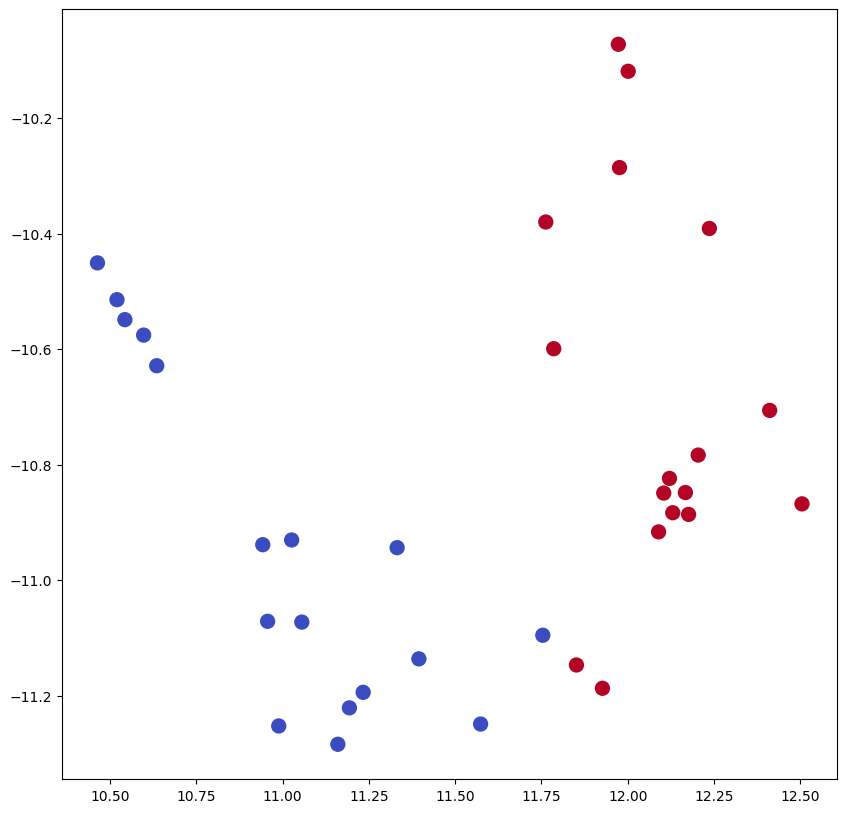

In [33]:
plt.figure(figsize=(10, 10), dpi=100)
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
plt.show()

### Modeling the classification model

In [36]:
X_train, X_test, y_train, y_test = train_test_split(nodes_vec, labels, test_size=.2, random_state=32, shuffle=True, stratify=labels)

In [38]:
print(f"Shape of the training data: {X_train.shape, y_train.shape}")
print(f"Shape of the test data: {X_test.shape, y_test.shape}")

Shape of the training data: ((27, 100), (27,))
Shape of the test data: ((7, 100), (7,))


In [40]:
rf = RandomForestClassifier(n_estimators=500, random_state=32, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=32)

In [43]:
print(f"Test score: {rf.score(X_test, y_test) * 100:.2f}%")

Test score: 100.00%
